In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_032
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    oof_exp: exp_031

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 7  # 3-8。7くらいでいい。
    colsample_bytree: 0.5  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,raw_step,event,score,step
0,038441c925bb,10907.5,wakeup,0.781264,10895
1,038441c925bb,27467.5,wakeup,0.888025,27455
2,038441c925bb,44099.5,wakeup,0.575580,44087
3,038441c925bb,61163.5,wakeup,0.606422,61151
4,038441c925bb,94307.5,wakeup,0.503569,94295


,target,step,series_id,fold,oof_stage1,STAGE_stage1,raw_oof,oof_stage2,STAGE_stage2,minutes,oof
0,1,11.5,038441c925bb,2,NaN,2,0.999819,NaN,NaN,NaN,NaN
1,1,35.5,038441c925bb,2,NaN,2,0.999644,NaN,NaN,NaN,NaN
2,1,59.5,038441c925bb,2,NaN,2,0.993865,NaN,NaN,NaN,NaN
3,1,83.5,038441c925bb,2,NaN,2,0.995005,NaN,NaN,NaN,NaN
4,1,107.5,038441c925bb,2,NaN,2,0.994551,NaN,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 正解ラベルを作成

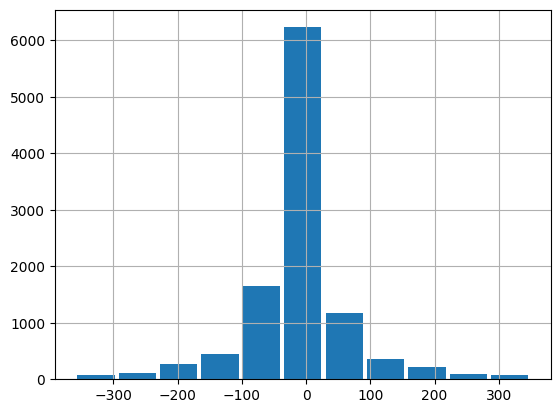

series_id    5331163
step         5331163
fold         5331163
raw_oof      5331163
minutes       692642
target         10720
sub_step       10720
raw_step       10720
event          10720
score          10720
dtype: int64

In [4]:
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 360:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "raw_step", "event", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [5]:
(oof.target ** 2).mean() ** 0.5

81.80591166190754

In [6]:
oof.head()

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score
0,038441c925bb,11.5,2,0.999819,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,2,0.999644,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,2,0.993865,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,2,0.995005,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,2,0.994551,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴生成

In [7]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    train["total_seconds"] = train.index * 5 *  CFG["feature"]["agg_freq"] % (24 * 60 * 60)
    features.add_num_feature("total_seconds")    

    # 分
    features.add_num_feature("minutes")

    # gap
    train["gap"] = train["sub_step"] - train["step"]
    train["sub_minutes"] = (train["minutes"] + train["gap"] * 12) % (60 * 60)
    features.add_num_features(["gap", "sub_minutes"])

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [1, 2, 3, 5, 10, 50]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1, 2]:
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)

    train = train.dropna(subset=["target"]).reset_index(drop=True)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [8]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

100%|██████████| 277/277 [02:28<00:00,  1.86it/s]


In [9]:
train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score,...,raw_oof_mean_rolling_max_50_shift_100_diff,raw_oof_rolling_min_50_shift_100_diff,raw_oof_diff_abs_rolling_min_50_shift_100_diff,raw_oof_mean_rolling_min_50_shift_100_diff,raw_oof_rolling_median_50_shift_100_diff,raw_oof_diff_abs_rolling_median_50_shift_100_diff,raw_oof_mean_rolling_median_50_shift_100_diff,raw_oof_rolling_square_mean_50_shift_100_diff,raw_oof_diff_abs_rolling_square_mean_50_shift_100_diff,raw_oof_mean_rolling_square_mean_50_shift_100_diff
0,038441c925bb,5027.5,2,0.105253,1737.5,-23.0,5015.0,5027.5,onset,0.882807,...,0.668921,0.969247,0.000000,0.710805,0.951029,-0.004294,0.703354,0.996470,-0.000052,0.896479
1,038441c925bb,10907.5,2,0.273098,2337.5,37.0,10895.0,10907.5,wakeup,0.781264,...,-0.603792,-0.919760,0.000712,-0.633497,-0.929680,0.008032,-0.612387,-0.981258,0.000148,-0.786321
2,038441c925bb,20363.5,2,0.222834,2817.5,-107.0,20351.0,20363.5,onset,0.615381,...,0.375216,0.956898,-0.000517,0.690591,0.881628,-0.019891,0.644810,0.982125,-0.001092,0.849739
3,038441c925bb,27467.5,2,0.692859,2337.5,37.0,27455.0,27467.5,wakeup,0.888025,...,-0.607667,-0.956193,0.000052,-0.560981,-0.941557,0.004191,-0.627637,-0.992964,0.000233,-0.752779
4,038441c925bb,40019.5,2,0.184147,297.5,-11.0,40007.0,40019.5,onset,0.870674,...,0.651438,0.949239,-0.000055,0.674680,0.930760,-0.004118,0.655324,0.991584,-0.000173,0.857233


(10720, 1041)


In [10]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [11]:
# 学習
trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
    int), params=CFG["xgboost"], es_rounds=100)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:75.93089
[50]	eval-rmse:72.04395
[100]	eval-rmse:70.32659
[150]	eval-rmse:69.49711
[200]	eval-rmse:69.11813
[250]	eval-rmse:68.98450
[300]	eval-rmse:68.93788
[350]	eval-rmse:68.97336
[388]	eval-rmse:69.00805


 20%|██        | 1/5 [00:29<01:59, 29.83s/it]

== fold 1 ==
[0]	eval-rmse:88.96609
[50]	eval-rmse:84.80643
[100]	eval-rmse:82.79418
[150]	eval-rmse:81.82354
[200]	eval-rmse:81.32107
[250]	eval-rmse:80.99837
[300]	eval-rmse:80.81579
[350]	eval-rmse:80.75512
[400]	eval-rmse:80.73103
[450]	eval-rmse:80.73324
[500]	eval-rmse:80.73463
[550]	eval-rmse:80.69017
[600]	eval-rmse:80.67950
[650]	eval-rmse:80.68621
[676]	eval-rmse:80.68437


 40%|████      | 2/5 [00:59<01:29, 29.95s/it]

== fold 2 ==
[0]	eval-rmse:86.43609
[50]	eval-rmse:83.17144
[100]	eval-rmse:81.95161
[150]	eval-rmse:81.54319
[200]	eval-rmse:81.51425
[250]	eval-rmse:81.47738
[300]	eval-rmse:81.56227
[342]	eval-rmse:81.58408


 60%|██████    | 3/5 [01:15<00:46, 23.29s/it]

== fold 3 ==
[0]	eval-rmse:77.86151
[50]	eval-rmse:74.81281
[100]	eval-rmse:73.74991
[150]	eval-rmse:73.42860
[200]	eval-rmse:73.30678
[250]	eval-rmse:73.31890
[300]	eval-rmse:73.43487
[324]	eval-rmse:73.43563


 80%|████████  | 4/5 [01:29<00:19, 19.87s/it]

== fold 4 ==
[0]	eval-rmse:80.15132
[50]	eval-rmse:76.23598
[100]	eval-rmse:74.55298
[150]	eval-rmse:73.87024
[200]	eval-rmse:73.59536
[250]	eval-rmse:73.48125
[300]	eval-rmse:73.42367
[350]	eval-rmse:73.45040
[389]	eval-rmse:73.45825


100%|██████████| 5/5 [01:46<00:00, 21.33s/it]


In [12]:
train = train[["step", "sub_step", "series_id", "score", "event", "oof", "target"]]

In [13]:
train["step"] = (train["sub_step"] + train["oof"]).astype(int)

In [14]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, train)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6682


event   tolerance
onset   12           0.096407
        36           0.416617
        60           0.585983
        90           0.683389
        120          0.736863
        150          0.772485
        180          0.796044
        240          0.820252
        300          0.836506
        360          0.847069
wakeup  12           0.111429
        36           0.439222
        60           0.588840
        90           0.689493
        120          0.745621
        150          0.788641
        180          0.812732
        240          0.845981
        300          0.867904
        360          0.882485
dtype: float64